In [47]:
import os
import wget
import threading
import numpy as np
import pandas as pd
from math import floor
from pydap.client import open_url
from tqdm import tqdm
import sys
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import cv2
plt.rcParams["figure.figsize"] = 10, 8

### Code to download data from MUR

In [16]:
def boundingindex(dmin, dint, boundary0, boundary1):
    """
    get boundaries values to download the data already cropped
    """
    inx0 = max(int(floor((boundary0 - dmin) / dint)), 0)
    inx1 = max(int(floor((boundary1 - dmin) / dint)), 0)
    if inx0 > inx1:
        atemp = inx0
        inx0 = inx1
        inx1 = atemp
    return [inx0, inx1]

In [17]:
def get_mur_params(lon_box, lat_box):
    """
    Check sample file to get parameters for sst
    """
    mur_ncin = open_url(
        'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/002/20180102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
    lon = mur_ncin['lon']
    lat = mur_ncin['lat']
    lon_step = np.mean(np.diff(lon))
    lat_step = np.mean(np.diff(lat))
    [mur_i0, mur_i1] = boundingindex(lon[0][0].data, lon_step, lon_box[0], lon_box[1])
    [mur_j0, mur_j1] = boundingindex(lat[0][0].data, lat_step, lat_box[0], lat_box[1])

    return mur_i0, mur_i1, mur_j0, mur_j1

In [13]:
def download_from_url(fileget, filenameout, replace, printiti):
    """
    function that tries to download data from "fileget" if the data didn't previously exist,
    the user asked to replace the old data, or the file has 0 bytes
    """
    exists = os.path.exists(filenameout)
    if exists:
        file_size = os.path.getsize(filenameout)
    else:
        file_size = 1
    if (not exists) or (replace and exists) or (file_size == 0):
        if exists:
            os.remove(filenameout)
        try:
            return wget.download(fileget, out=filenameout, bar=None)
        except Exception as e:
            if printiti:
                print(e)
                print("Error downloading")
                print("Download error url: " + fileget)
            return e
    return filenameout

In [14]:
def download_sst(path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    opendap_dir = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/' + str(
        date.year) + '/'
    filename = opendap_dir + "{0:0>3}".format(str(date.dayofyear)) + '/' + date.strftime(
        "%Y%m%d") + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.nc4'
    filenameout = path + "sst_" + date.strftime("%Y%m%d") + '.nc'
    fileget = filename + '?analysed_sst[0:1:0][' + str(mur_j0) + ':1:' + str(mur_j1) + '][' + str(mur_i0) + ':1:' + str(
        mur_i1) + ']'
    download_from_url(fileget, filenameout, replace, 1)
    return

In [28]:
download_sst(path = "../data/", date = pd.to_datetime('20190725'), mur_j0=12499, mur_j1=13499, mur_i0=16099, mur_i1=17499, replace=None)

### Importação dos dados do MUR

Para já apenas foi feito o download relativo ao dia 25 de Julho de 2019

Importar o ficheiro netCDF da pasta data do repositório e depois converte-lo para o formato de dataframe

In [191]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [192]:
from pathlib import Path

data_folder = os.path.join(current_path,"../data")
data_folder

'/home/luisfigueiredo/JUNO/notebooks/../data'

In [193]:
nc_path = os.path.join(data_folder, "sst_20190725.nc")
ds = nc.Dataset(nc_path)
data = xr.load_dataset(nc_path)

In [194]:
print(ds) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.7
    title: Daily MUR SST, Final product
    summary: A merged, multi-sensor L4 Foundation SST analysis product from JPL.
    references: http://podaac.jpl.nasa.gov/Multi-scale_Ultra-high_Resolution_MUR-SST
    institution: Jet Propulsion Laboratory
    history: created at nominal 4-day latency; replaced nrt (1-day latency) version.
2022-03-09 17:24:48 GMT Hyrax-1.16.0 https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2019/206/20190725090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.nc4?analysed_sst[0:1:0][12499:1:13499][16099:1:17499]
    comment: MUR = \"Multi-scale Ultra-high Resolution\"
    license: These data are available free of charge under data policy of JPL PO.DAAC.
    id: MUR-JPL-L4-GLOB-v04.1
    naming_authority: org.ghrsst
    product_version: 04.1
    uuid: 27665bc0-d5fc-11e1-9b23-0800200c9a66
    gds_version_i

In [195]:
#Converter o ficheiro netCDF para uma dataframe
datadf = data.to_dataframe()
datadf = datadf.reset_index()

In [196]:
datadf['analysed_sst'] =  datadf['analysed_sst']-273.15    #convert to celsius
datadf

,lat,lon,time,analysed_sst
0,35.0,-19.000000,2019-07-25 09:00:00,22.924988
1,35.0,-18.990000,2019-07-25 09:00:00,22.945007
2,35.0,-18.980000,2019-07-25 09:00:00,22.971985
3,35.0,-18.969999,2019-07-25 09:00:00,23.001007
4,35.0,-18.959999,2019-07-25 09:00:00,23.029999
...,...,...,...,...
1402396,45.0,-5.040000,2019-07-25 09:00:00,21.966003
1402397,45.0,-5.030000,2019-07-25 09:00:00,21.977997
1402398,45.0,-5.020000,2019-07-25 09:00:00,21.980011
1402399,45.0,-5.010000,2019-07-25 09:00:00,21.975006


### Aplicar o canny para a dataframe em questão

In [197]:
#Pegar na df dum dia e converte-la num np array com os valores de Temperatura para os valores de long e lati
sst = datadf.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values

In [198]:
sst = np.flipud(sst)   #flipud -> Reverse the order of elements along axis 0 (up/down).

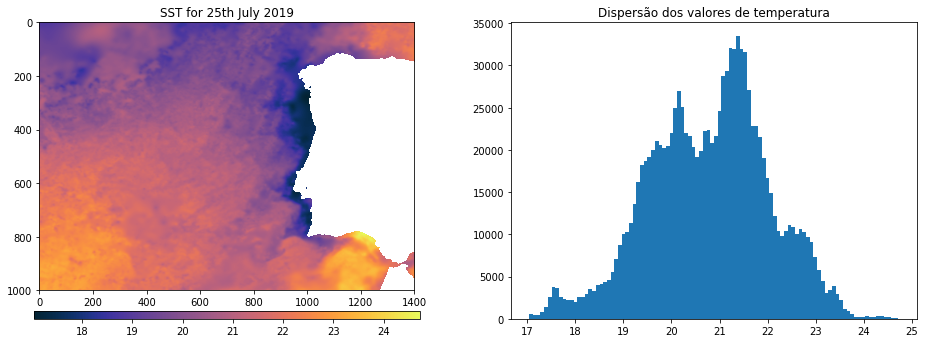

In [199]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
import cmocean
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
img = ax1.imshow(sst, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = 16, 12
plt.colorbar(img, orientation='horizontal', fraction=0.026, pad=0.07, aspect=50)
plt.title('SST for 25th July 2019')

ax2 = fig.add_subplot(2,2,2)
ax2.hist(sst.flatten(), bins=100);
plt.title('Dispersão dos valores de temperatura');
#plt.ylim([0, 10000]);

In [200]:
#Pegar na df dum dia e converte-la num np array com os valores de Temperatura para os valores de long e lati
sst2 = datadf.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values
    
#Converter os valores de temperatura no formato uint8 com valores entre 0-255
sst2 = ((sst2 - np.nanmin(sst2)) * (1/(np.nanmax(sst2) - np.nanmin(sst2)) * 255)).astype('uint8')

sst2 = np.flipud(sst2)   #flipud -> Reverse the order of elements along axis 0 (up/down).

In [201]:
sst2

array([[ 61,  61,  61, ..., 163, 163, 163],
       [ 61,  61,  61, ..., 162, 162, 162],
       [ 62,  61,  61, ..., 162, 162, 161],
       ...,
       [194, 195, 196, ...,   0,   0,   0],
       [194, 195, 196, ...,   0,   0,   0],
       [195, 196, 196, ...,   0,   0,   0]], dtype=uint8)

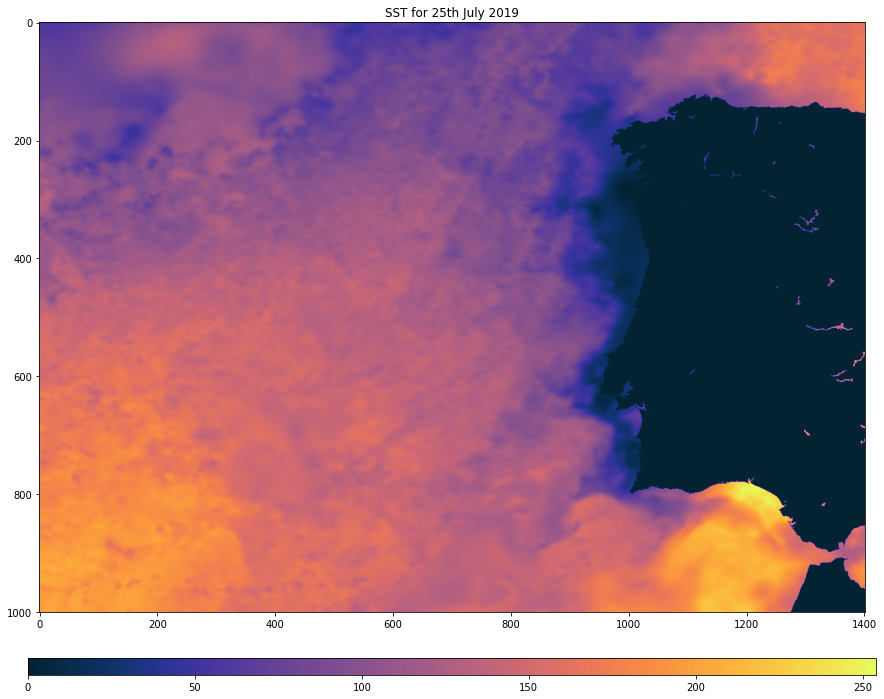

In [203]:
img2 = plt.imshow(sst2, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = 16, 12
plt.colorbar(img2, orientation='horizontal', fraction=0.026, pad=0.07, aspect=50)
plt.title('SST for 25th July 2019');

In [ ]:
#apply the canny algorithm and plot the image with the edges
canny = cv2.Canny(Temp_day, 220, 220, L2gradient=False, apertureSize=5)
    
#mask = np.isnan(np.flipud(Temp))    #Boolean array é True onde o array original (Temp) tinha valores Nan
#mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array cujos pixels= 255 quando mask=True
#Fazer uma dilatação para assegurar que os pixeis que pertencem à costa não são considerados como frentes no canny
#kernel = np.ones((3,3), np.uint8)
#mask_dilated = cv2.dilate(mask255, kernel)
#canny =np.ma.masked_where(mask_dilated==255, canny)

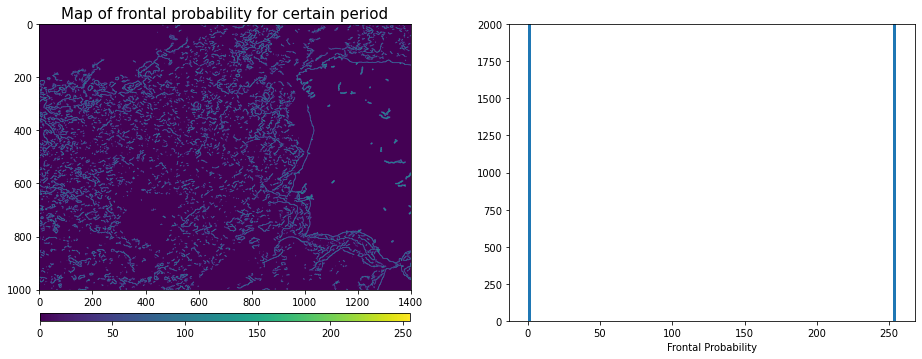

In [103]:
    
plt.rcParams["figure.figsize"] = 16, 12
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
img = ax1.imshow(canny) 
plt.colorbar(img, orientation='horizontal', fraction=0.025, pad=0.08, aspect=50)
plt.title("Map of frontal probability for certain period", fontsize=15)

ax2 = fig.add_subplot(2,2,2)
ax2.hist(canny.flatten(), bins=100);
plt.xlabel('Frontal Probability',fontsize=10)
plt.ylim([0, 2000]);